In [1]:
import pandas as pd
import numpy as np
from os import path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from config import *
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv(path.join(DATA_DIR, TRAIN_FILE))
test_df = pd.read_csv(path.join(DATA_DIR, TEST_FILE))


op_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
op_df['PassengerId'] = test_df['PassengerId']
train_target = train_df['Survived']

In [3]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
    
def replace_titles(x):
    title = x['Title']
    sex = x['Sex']
    age = x['Age']
    if title in ['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Mme', 'Ms', 'Lady', 'Sir', 'Mlle', 'the Countess', 'Jonkheer']:
        if (sex in ['male']) & (age > 12.0):
            return 'Mr'
        elif (sex in ['male']) & (age <= 12.0):
            return 'Master'
        elif (sex in ['female']) & (age <= 28.0):
            return 'Miss'
        else:
            return 'Mrs'
    else:
        return title

In [4]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

train_df['Title'] = train_df['Name'].map(lambda x: get_title(x))
train_df['Title'] = train_df.apply(replace_titles, axis=1)
test_df['Title'] = test_df['Name'].map(lambda x: get_title(x))
test_df['Title'] = test_df.apply(replace_titles, axis=1)

train_df['Age'] = train_df['Age'].fillna(train_df.groupby("Title")['Age'].transform("mean"))
test_df['Age'] = test_df['Age'].fillna(test_df.groupby("Title")['Age'].transform("mean"))

train_df['Fare'] = train_df['Fare'].fillna(train_df.groupby("Pclass")['Fare'].transform("mean"))
test_df['Fare'] = test_df['Fare'].fillna(test_df.groupby("Pclass")['Fare'].transform("mean"))

In [5]:
drop_cols = ['Name', 'Ticket', 'Cabin']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Title'],
      dtype='object')

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,Mr


In [8]:
join_df = train_df.drop(columns=['Survived']).append(test_df, ignore_index=True)

In [9]:
join_df.shape

(1309, 9)

In [10]:
join_df['Sex'] = LabelEncoder().fit_transform(join_df['Sex'])
join_df['Embarked'] = LabelEncoder().fit_transform(join_df['Embarked'])
join_df['Title'] = LabelEncoder().fit_transform(join_df['Title'])

In [11]:
train_df = join_df[:len(train_df)]
test_df = join_df[len(train_df):]

X_train, X_val, y_train, y_val = train_test_split(train_df, train_target, test_size=0.30, random_state=20)

Feature importance plot



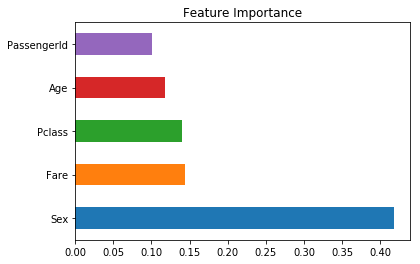

Cross validated scores: [0.832     0.792     0.832     0.84      0.8699187]
Cross Predicted Accuracy: 0.0026410564225688438
Confusion Matrix: 
 [[145  25]
 [ 37  61]]


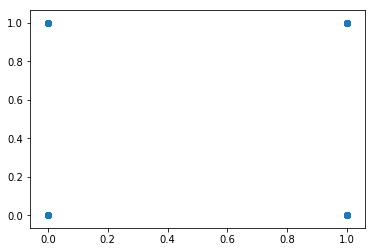

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

print("Feature importance plot\n")
feat_importances = pd.Series(gbc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

scores = cross_val_score(gbc, X_train, y_train, cv=5)
print("Cross validated scores:", scores)

pred = cross_val_predict(gbc, X_val, y_val, cv=5)

accuracy = metrics.r2_score(y_val, pred)
print("Cross Predicted Accuracy:", accuracy)

print("Confusion Matrix: \n", metrics.confusion_matrix(y_val, pred, labels=[0, 1]))
plt.scatter(y_val, pred)

In [14]:
op_df['Survived'] = gbc.predict(test_df).astype(int)

op_df.to_csv('gbc_pred.csv', index=None)